<a href="https://colab.research.google.com/github/marcio-lfo/devai/blob/main/Grupo_3_Projeto_2_Base_LE_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconhecimento de Entidades Nomeadas**

Grupo 3

# **Projeto 2**

**Objetivo**: Estender os códigos desenvolvidos em sala
para incorporar a base de dados ulysses-ner-br.

Base de dados: **LE-NER**

In [1]:
!python -m pip install --upgrade pip
!pip install seqeval
!pip install -U sklearn_crfsuite
!pip install scikit-learn==1.3.2

!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 650.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a79d1882247eac92810fc6ee999f27259a6d681b16157883d7a046c6e977a2e9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
2023-12-11 17:07:48.000821: E ten

In [2]:
import os
import numpy as np

from sklearn_crfsuite import CRF
from seqeval.metrics import classification_report

In [3]:
!wget https://raw.githubusercontent.com/messias077/ner_pt/main/data/corpora/le_ner/train.conll
!wget https://raw.githubusercontent.com/messias077/ner_pt/main/data/corpora/le_ner/test.conll

--2023-12-11 17:08:24--  https://raw.githubusercontent.com/messias077/ner_pt/main/data/corpora/le_ner/train.conll
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2142199 (2.0M) [text/plain]
Saving to: ‘train.conll’

train.conll         100%[===================>]   2.04M  --.-KB/s    in 0.07s   

2023-12-11 17:08:25 (29.1 MB/s) - ‘train.conll’ saved [2142199/2142199]

--2023-12-11 17:08:25--  https://raw.githubusercontent.com/messias077/ner_pt/main/data/corpora/le_ner/test.conll
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43844

In [4]:
!wget https://raw.githubusercontent.com/ulysses-camara/ulysses-ner-br/main/annotated-corpora/PL_corpus_conll/pl_corpus_categorias/train.txt -O train_ulysses.pl.conll
!wget https://raw.githubusercontent.com/ulysses-camara/ulysses-ner-br/main/annotated-corpora/PL_corpus_conll/pl_corpus_categorias/test.txt -O test_ulysses.pl.conll

--2023-12-11 17:08:32--  https://raw.githubusercontent.com/ulysses-camara/ulysses-ner-br/main/annotated-corpora/PL_corpus_conll/pl_corpus_categorias/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 779304 (761K) [text/plain]
Saving to: ‘train_ulysses.pl.conll’

train_ulysses.pl.co 100%[===================>] 761.04K  --.-KB/s    in 0.06s   

2023-12-11 17:08:32 (13.4 MB/s) - ‘train_ulysses.pl.conll’ saved [779304/779304]

--2023-12-11 17:08:32--  https://raw.githubusercontent.com/ulysses-camara/ulysses-ner-br/main/annotated-corpora/PL_corpus_conll/pl_corpus_categorias/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

## Função para leitura da base de dados no padrão BIO

In [5]:
def read_corpus_file(corpus_file, delimiter='\t', ner_column=1):
    with open(corpus_file, encoding='utf-8') as file:
        lines = file.readlines()
    data = []
    words = []
    tags = []
    for line in lines:
        line = line.replace('\n', '')
        if line != '':
            if delimiter in line:
                fragments = line.split(delimiter)
                words.append(fragments[0])
                tags.append(fragments[ner_column])
        else:
            if len(words) > 1:
                data.append((words, tags))
            words = []
            tags = []
    return data

In [6]:
corpus_name = 'le_ner'
#corpus_name = 'ulysses_ner' # Acrescentar a base de dados da tarefa

report_dir = 'report/'

train_file = None
test_file = None

delimiter = '\t'

if corpus_name == 'le_ner':
    train_file = '/content/train.conll'
    test_file = '/content/test.conll'
    delimiter = ' '
    id = 1
elif corpus_name == 'ulysses_ner':
    train_file = '/content/train_ulysses.pl.conll'
    test_file = '/content/test_ulysses.pl.conll'
    delimiter = ' '
    id = 1

print(f'\nCorpus: {corpus_name}')

report_dir = os.path.join(report_dir, corpus_name)

os.makedirs(report_dir, exist_ok=True)

train_data = read_corpus_file(train_file, delimiter=delimiter, ner_column=id)
test_data = read_corpus_file(test_file, delimiter=delimiter, ner_column=id)

print(f'\nTrain data: {len(train_data)}')
print(f'Test data: {len(test_data)}')


Corpus: le_ner

Train data: 7821
Test data: 1389


In [7]:
train_data[0]

(['EMENTA',
  ':',
  'APELAÇÃO',
  'CÍVEL',
  '-',
  'AÇÃO',
  'DE',
  'INDENIZAÇÃO',
  'POR',
  'DANOS',
  'MORAIS',
  '-',
  'PRELIMINAR',
  '-',
  'ARGUIDA',
  'PELO',
  'MINISTÉRIO',
  'PÚBLICO',
  'EM',
  'GRAU',
  'RECURSAL',
  '-',
  'NULIDADE',
  '-',
  'AUSÊNCIA',
  'DE',
  'INTERVENÇÃO',
  'DO',
  'PARQUET',
  'NA',
  'INSTÂNCIA',
  'A',
  'QUO',
  '-',
  'PRESENÇA',
  'DE',
  'INCAPAZ',
  '-',
  'PREJUÍZO',
  'EXISTENTE',
  '-',
  'PRELIMINAR',
  'ACOLHIDA',
  '-',
  'NULIDADE',
  'RECONHECIDA',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORGANIZACAO',
  'I-ORGANIZACAO',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

## Função que executa o pré-processamento do corpus usando a ferramenta Spacy

In [8]:
import spacy

def data_preprocessing(data):
    nlp = spacy.load(name='pt_core_news_sm',
                     disable=['parser', 'ner', 'lemmatizer', 'textcat'])
    preprocessed_data = []
    for d in data:
        sentence = ' '.join(d[0])
        doc = nlp(sentence)
        pos_tags = [t.pos_ for t in doc]
        preprocessed_data.append((d[0], pos_tags, d[1]))
    return preprocessed_data

In [9]:
train_data = data_preprocessing(train_data)
test_data = data_preprocessing(test_data)

In [10]:
train_data[0]

(['EMENTA',
  ':',
  'APELAÇÃO',
  'CÍVEL',
  '-',
  'AÇÃO',
  'DE',
  'INDENIZAÇÃO',
  'POR',
  'DANOS',
  'MORAIS',
  '-',
  'PRELIMINAR',
  '-',
  'ARGUIDA',
  'PELO',
  'MINISTÉRIO',
  'PÚBLICO',
  'EM',
  'GRAU',
  'RECURSAL',
  '-',
  'NULIDADE',
  '-',
  'AUSÊNCIA',
  'DE',
  'INTERVENÇÃO',
  'DO',
  'PARQUET',
  'NA',
  'INSTÂNCIA',
  'A',
  'QUO',
  '-',
  'PRESENÇA',
  'DE',
  'INCAPAZ',
  '-',
  'PREJUÍZO',
  'EXISTENTE',
  '-',
  'PRELIMINAR',
  'ACOLHIDA',
  '-',
  'NULIDADE',
  'RECONHECIDA',
  '.'],
 ['PROPN',
  'PUNCT',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'ADP',
  'PROPN',
  'ADP',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'VERB',
  'ADP',
  'PROPN',
  'PROPN',
  'ADP',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'X',
  'ADP',
  'PROPN',
  'ADP',
  'PROPN',
  'ADP',
  'NOUN',
  'DET',
  'PROPN',
  'PUNCT',
  'PROPN',
  'ADP',
  'PROPN',
  'PUNCT',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'NOUN',

## Funções usadas para extrair as features dos tokens e de seus vizinhos.

In [11]:
def extract_sent_features(sentence):
    return [extract_features(sentence, i) for i in range(len(sentence))]


def extract_labels(sentence):
    return [label for _, _, label in sentence]


def extract_features(sentence, i):
    word = sentence[i][0]
    postag = sentence[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'word.islower()': word.islower(),
        'word[0].isupper()': word[0].isupper(),
        'word[0].islower()': word[0].islower(),
        'not word[0].isalnum()': not word[0].isalnum(),
        'not word.isalnum()': not word.isalnum(),
        'word.isalpha()': word.isalpha(),
        'size': len(word)
    }
    if i > 0:
        word1 = sentence[i - 1][0]
        postag1 = sentence[i - 1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:word.islower()': word1.islower()
        })
    else:
        features['BOS'] = True #Begin of Sentence
    if i > 1:
        word1 = sentence[i - 2][0]
        postag1 = sentence[i - 2][1]
        features.update({
            '-2:word.lower()': word1.lower(),
            '-2:word.istitle()': word1.istitle(),
            '-2:word.isupper()': word1.isupper(),
            '-2:postag': postag1,
            '-2:postag[:2]': postag1[:2],
            '-2:word.islower()': word1.islower()
        })
    if i < len(sentence) - 1:
        word1 = sentence[i + 1][0]
        postag1 = sentence[i + 1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:word.islower()': word1.islower()
        })
    else:
        features['EOS'] = True
    if i < len(sentence) - 2:
        word1 = sentence[i + 2][0]
        postag1 = sentence[i + 2][1]
        features.update({
            '+2:word.lower()': word1.lower(),
            '+2:word.istitle()': word1.istitle(),
            '+2:word.isupper()': word1.isupper(),
            '+2:postag': postag1,
            '+2:postag[:2]': postag1[:2],
            '+2:word.islower()': word1.islower()
        })
    return features


def convert_data(data):
    sentences = []
    for d in data:
        sentences.append(list(zip(d[0], d[1], d[2])))
    x_data = [extract_sent_features(s) for s in sentences]
    y_data = [extract_labels(s) for s in sentences]
    return x_data, y_data

In [12]:
## Convertendo os dados pré-processados para o formato necessário para o CRF
X_train, y_train = convert_data(train_data)
X_test, y_test = convert_data(test_data)

In [13]:
print(f'\nExample Feature: {X_train[0]}')

print(f'\nLabel: {y_train[0]}')


Example Feature: [{'bias': 1.0, 'word.lower()': 'ementa', 'word[-3:]': 'NTA', 'word[-2:]': 'TA', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'PROPN', 'postag[:2]': 'PR', 'word.islower()': False, 'word[0].isupper()': True, 'word[0].islower()': False, 'not word[0].isalnum()': False, 'not word.isalnum()': False, 'word.isalpha()': True, 'size': 6, 'BOS': True, '+1:word.lower()': ':', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'PUNCT', '+1:postag[:2]': 'PU', '+1:word.islower()': False, '+2:word.lower()': 'apelação', '+2:word.istitle()': False, '+2:word.isupper()': True, '+2:postag': 'PROPN', '+2:postag[:2]': 'PR', '+2:word.islower()': False}, {'bias': 1.0, 'word.lower()': ':', 'word[-3:]': ':', 'word[-2:]': ':', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'PUNCT', 'postag[:2]': 'PU', 'word.islower()': False, 'word[0].isupper()': False, 'word[0].islower()': False, 'not word[0].isalnum(

In [14]:
#crf = CRF(max_iterations=100, c1=0.1, c2=0.1, all_possible_transitions=False)
#crf = CRF(max_iterations=100, c1=0.1, c2=0.1, all_possible_transitions=np.true_divide)
crf = CRF(max_iterations=100, c1=0.1, c2=0.1, all_possible_transitions=True)

#Testar com max_iterations=100, all_possible_transitions=True



In [15]:
try:
  crf.fit(X_train, y_train)
except AttributeError:
  pass

In [16]:
y_pred = crf.predict(X_test)

In [17]:
report = classification_report(y_test, y_pred, digits=4)
print(f'\nCorpus: {corpus_name}')
print(report)


Corpus: le_ner
                precision    recall  f1-score   support

JURISPRUDENCIA     0.7416    0.7135    0.7273       185
    LEGISLACAO     0.8384    0.7963    0.8168       378
         LOCAL     0.7209    0.6596    0.6889        47
   ORGANIZACAO     0.8970    0.7824    0.8358       501
        PESSOA     0.8806    0.7597    0.8157       233
         TEMPO     0.9333    0.8021    0.8627       192

     micro avg     0.8583    0.7728    0.8133      1536
     macro avg     0.8353    0.7523    0.7912      1536
  weighted avg     0.8605    0.7728    0.8139      1536



In [18]:
import pandas as pd

## Criando um DataFrame para os dados da tarefa Ulysses-NER-BR e da PL_corpus_categorias
data_corpus = {'Sentences': [' '.join(sent) for sent, _, _ in test_data],
           'Labels': y_pred}

df_corpus = pd.DataFrame(data_corpus)

## Salvando os DataFrames como arquivos CSV
df_corpus.to_csv(corpus_name+'_predictions.csv', index=False)

## Exibindo os valores da tabela para comparação
print(f'\nCorpus: {corpus_name}')
print(df_corpus.head())


Corpus: le_ner
                                           Sentences  \
0  Número do Acórdão ACÓRDÃO 1160/2016 - PLENÁRIO...   
1         Interessado / Responsável / Recorrente 3 .   
2      Interessados/Responsáveis/Recorrentes : 3.1 .   
3  Interessado : Superior Tribunal Militar ( 00.4...   
4  Responsáveis : Aldo da Silva Fagundes ( 000.21...   

                                              Labels  
0  [O, O, O, B-JURISPRUDENCIA, I-JURISPRUDENCIA, ...  
1                              [O, O, O, O, O, O, O]  
2                                       [O, O, O, O]  
3  [O, O, B-ORGANIZACAO, I-ORGANIZACAO, I-ORGANIZ...  
4  [O, O, B-PESSOA, I-PESSOA, I-PESSOA, I-PESSOA,...  


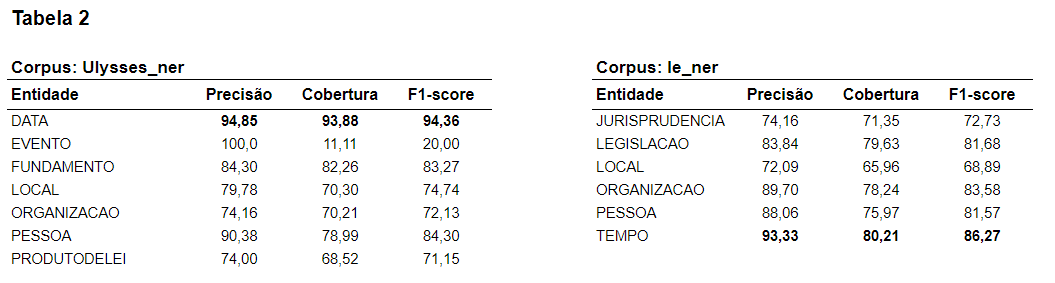